In [110]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from skopt import BayesSearchCV
from skopt.space import Real, Integer
import xgboost as xgb
from sklearn.metrics import accuracy_score, mean_absolute_error,mean_squared_error
from tensorflow import keras
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import shap
import os
import json
import re
import numpy as np
from pathlib import Path
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [55]:
bmi_training = pd.read_parquet('../data/processed/bmi_training.parquet')

X = bmi_training.iloc[:,:-1]
y = bmi_training.iloc[:,-1]

X_train,X_test,y_train,y_test = train_test_split(X,y, random_state=42)

<Axes: ylabel='Frequency'>

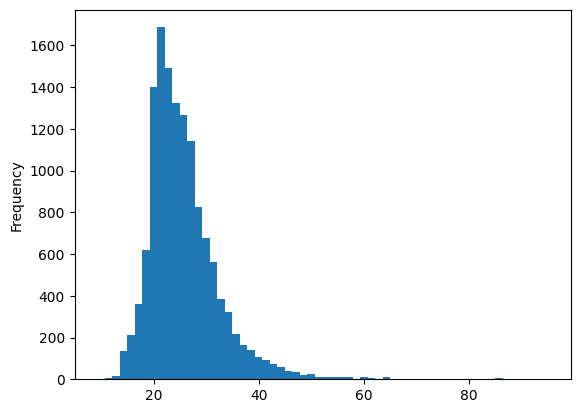

In [62]:
y.plot(kind='hist', bins = 60)

## XGBoost

In [ ]:
regressor = xgb.XGBRegressor(
    n_estimators=400,
    max_depth=10,
)

cv = KFold(n_splits=5, shuffle=True, random_state=42)

opt = BayesSearchCV(
    regressor,
    {
        'learning_rate': Real(1e-3, 0.3, prior="log-uniform"),
        'subsample': Real(0.5, 1.0),
        'colsample_bytree': Real(0.5, 1.0),
        'reg_lambda': Real(1e-3, 10.0, prior="log-uniform"),
        'reg_alpha': Real(1e-3, 10.0, prior="log-uniform"),
    },
    n_iter=10,
    scoring="neg_mean_squared_error",
    cv=cv,
    verbose=1,
    n_jobs=-1
)

opt.fit(X_train,y_train)

print(opt.best_params_)
print(opt.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
OrderedDict([('colsample_bytree', 0.549852303407526), ('learning_rate', 0.047013764552621684), ('reg_alpha', 0.013670939183544938), ('reg_lambda', 0.006594393518045071), ('subsample', 0.5877427364231569)])
-32.70560456781071


In [112]:
#save params
dump_path = '../params/best_params_bmi_regression_xgboost.json'
file_mode = 'x' if not Path(dump_path).exists() else 'w'
with open(dump_path, file_mode) as f:
    json.dump(opt.best_params_, f)

#save model
best_model = opt.best_estimator_
best_model.save_model('../saved_models/bmi_regression_xgboost_model.json')

In [113]:
y_pred = best_model.predict(X_test)

xgb_rmse = np.sqrt(mean_squared_error(y_test,y_pred))
xgb_mae = mean_absolute_error(y_test,y_pred)
print('RMSE:',xgb_rmse,'MAE:',xgb_mae)

RMSE: 5.694530563979028 MAE: 3.907301989163547


In [114]:
pred_scatter = px.scatter(
    x=y_test,
    y=y_pred,
    labels={'x': 'True BMI', 'y': 'Predicted BMI'},
)

identity = go.Scatter(
    x=np.linspace(min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max()), 100),
    y=np.linspace(min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max()), 100),
    mode="lines",
    line=dict(color="red", dash="dash"),
    name="y = x",
)

pred_scatter.add_trace(identity)
pred_scatter.update_traces(marker=dict(size=5, opacity=0.1))
pred_scatter.show()


/opt/anaconda3/envs/ml/lib/python3.9/site-packages/shap/plots/_beeswarm.py:1150: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.



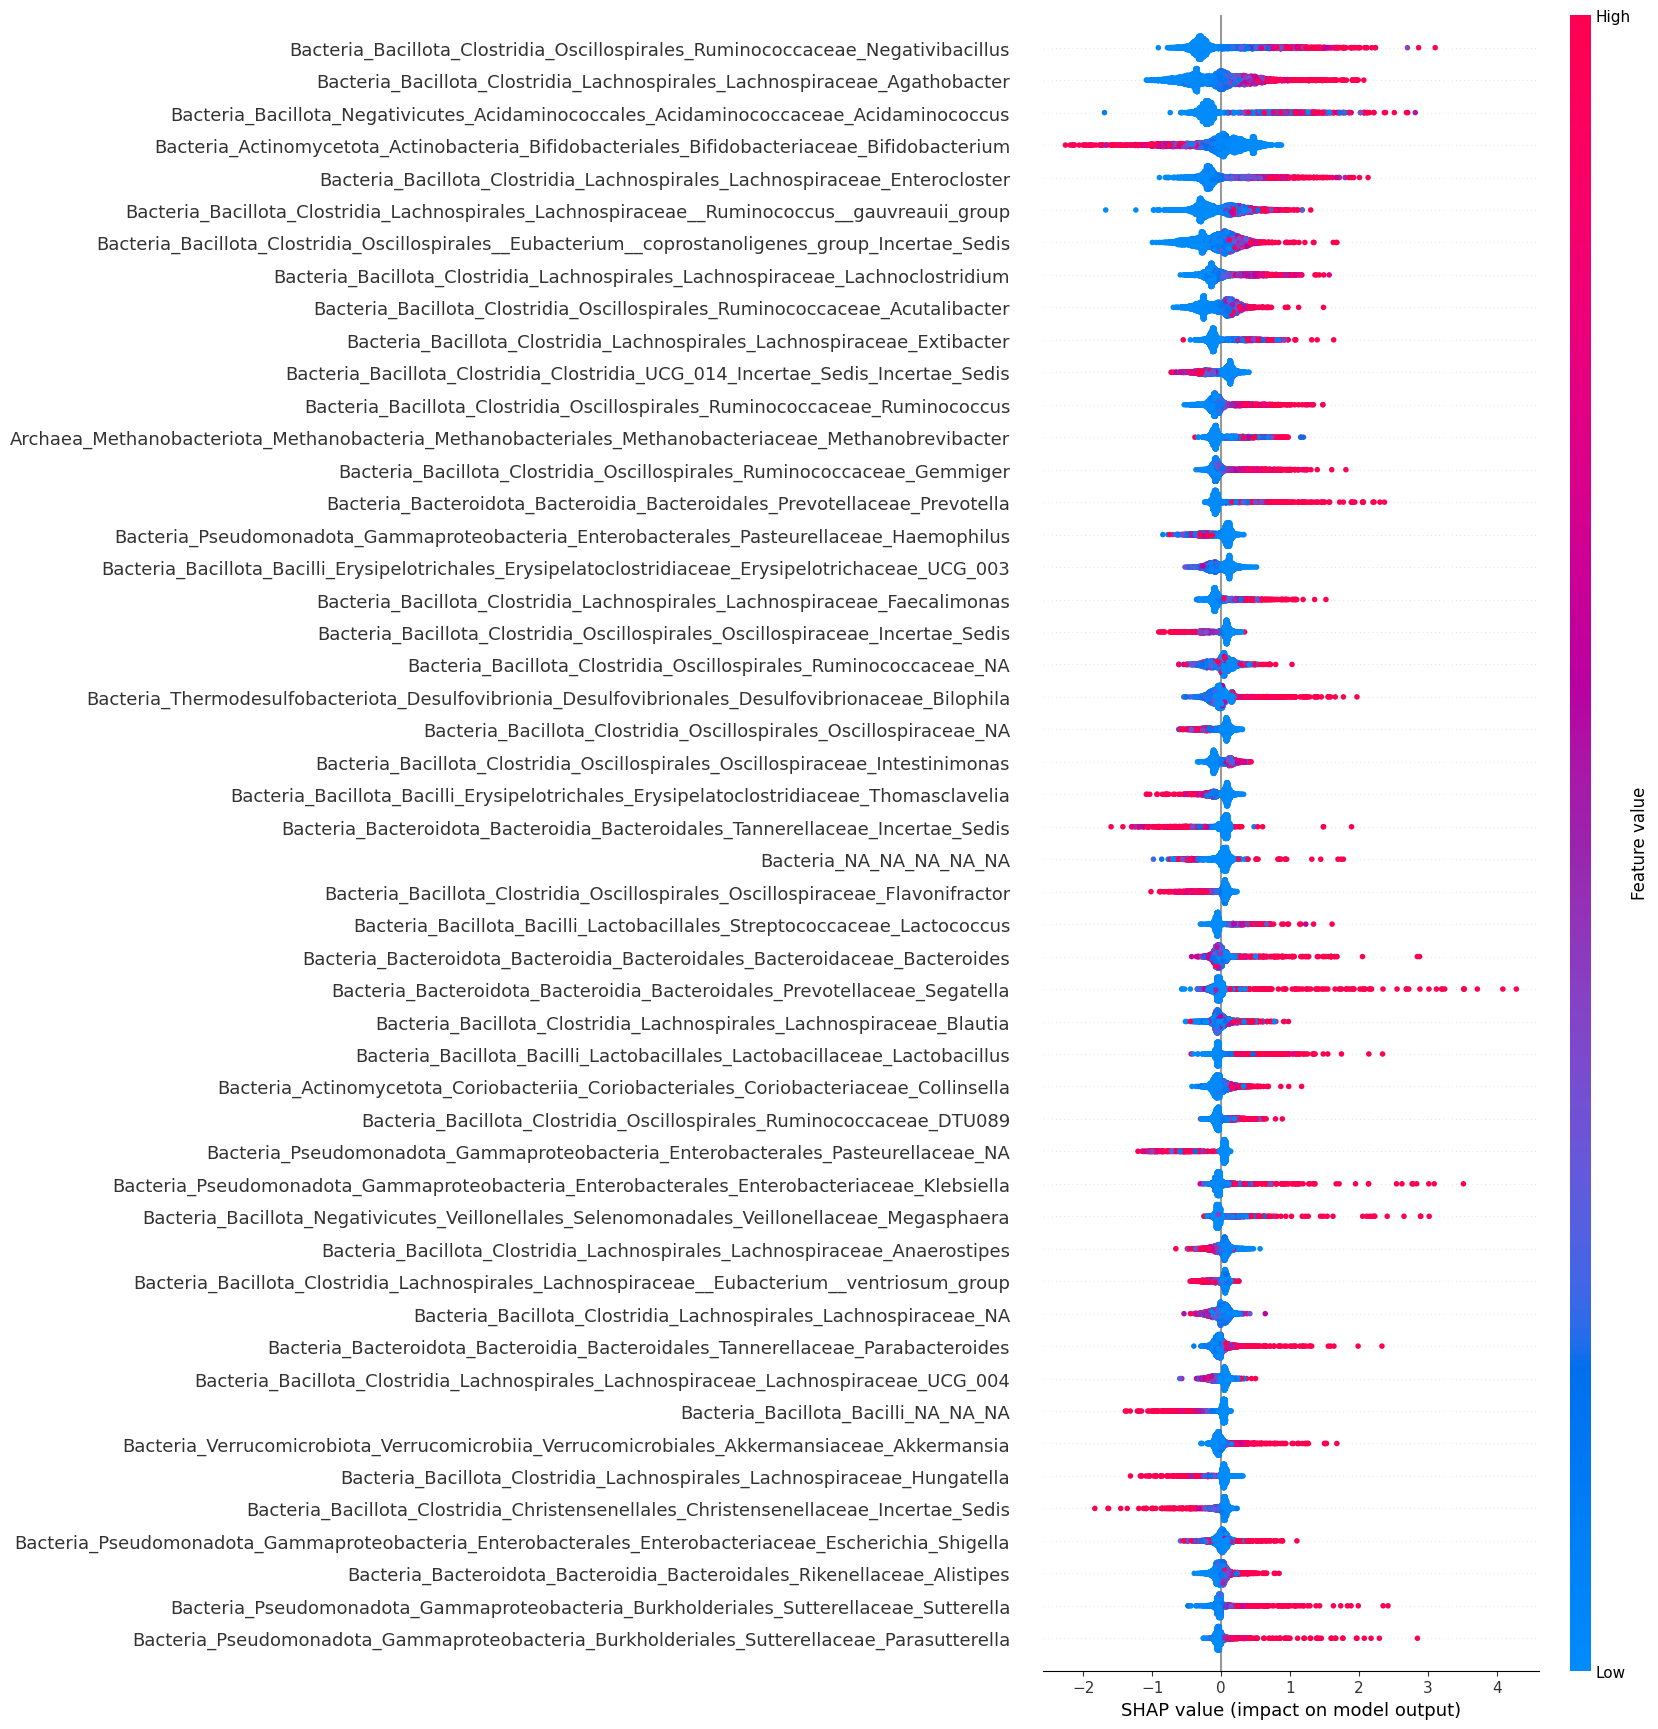

In [116]:
explainer = shap.TreeExplainer(best_model)

shap_values = explainer.shap_values(X_test)

shap.summary_plot(
    shap_values,
    X_test,
    feature_names=X_test.columns,  # set to None if you’re fine with default col names
    max_display=50,
)


## neural net

In [ ]:
model = keras.Sequential([
    keras.layers.Input((X_train.shape[1],)),
    #keras.layers.Dense(512,activation='relu'),
    keras.layers.Dense(256,activation='relu'),
    keras.layers.Dense(64,activation='relu'),
    keras.layers.Dense(1)
])

model.compile(
    loss='mse',
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=['mae']
)

history = model.fit(
    X_train,
    y_train,
    epochs=40,
    batch_size=1028,
    validation_split=0.1,
    verbose = 1
)

loss_fig = go.Figure()

loss_fig.add_trace(
    go.Scatter(
        x=history.epoch,
        y=history.history['loss'],
        mode='lines',
        name='loss',
    )
)

loss_fig.add_trace(
    go.Scatter(
        x=history.epoch,
        y=history.history['val_loss'],
        mode='lines',
        name='val_loss',
    )
)

loss_fig.update_layout(
    title='training loss',
    xaxis_title='epoch',
    yaxis_title='mse',
)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 698.5906 - mae: 25.5683 - val_loss: 679.7084 - val_mae: 25.2008
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 670.3658 - mae: 25.0386 - val_loss: 647.2864 - val_mae: 24.5490
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 637.3398 - mae: 24.3540 - val_loss: 597.5360 - val_mae: 23.5139
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 585.7651 - mae: 23.2696 - val_loss: 527.8630 - val_mae: 21.9826
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 512.5461 - mae: 21.6107 - val_loss: 437.3520 - val_mae: 19.8173
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 410.5126 - mae: 19.1338 - val_loss: 329.9680 - val_mae: 16.8919
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 299.7615 - mae: 15.9801 - val_loss: 217.3865 - val_mae: 13.1436
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 192.8230 - mae: 12.1214 - val_loss: 120.2715 - val_mae: 8.8249
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━

In [102]:
nn_preds = model.predict(X_test)
print('RMSE:',np.sqrt(mean_squared_error(y_test,nn_preds)),'MAE:',mean_absolute_error(y_test,nn_preds))

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
RMSE: 6.4844428021378056 MAE: 4.625640990594956


In [107]:
pred_scatter = px.scatter(
    x=y_test,
    y=nn_preds[:,0],
    labels={'x': 'True BMI', 'y': 'Predicted BMI'},
)

identity = go.Scatter(
    x=np.linspace(min(y_test.min(), nn_preds.min()), max(y_test.max(), nn_preds.max()), 100),
    y=np.linspace(min(y_test.min(), nn_preds.min()), max(y_test.max(), nn_preds.max()), 100),
    mode="lines",
    line=dict(color="red", dash="dash"),
    name="y = x",
)

pred_scatter.add_trace(identity)
pred_scatter.update_traces(marker=dict(size=5, opacity=0.1))
pred_scatter.show()
